# Kalman Filter Design for Pmod Nav

Simulate Pmod Nav Sensor to test Kalman Filter. Initialized with angle position, angle rate and noise standard deviation. Each call to `read()` updates the position by one time step and returns the new measurement.

In [4]:
from numpy.random import randn

class NavSensor(object):
    def __init__(self, angle=(0, 0, 0), angle_rate=(0, 0 ,0), noise_std=1.):
        self.angle_rate = angle_rate
        self.noise_std = noise_std
        self.angle = [angle[0], angle[1], angle[2]]
        
    def read(self):
        self.angle[0] += self.angle_rate[0]
        self.angle[1] += self.angle_rate[1]
        self.angle[2] += self.angle_rate[2]
        
        return [self.angle[0] + randn() * self.noise_std,
                self.angle[1] + randn() * self.noise_std,
                self.angle[2] + randn() * self.noise_std]

Testing that sensor simulation works

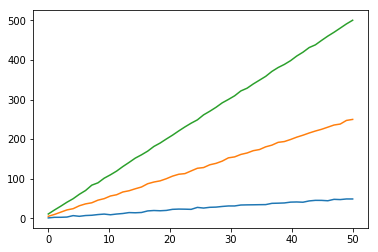

In [7]:
import matplotlib.pyplot as plt
import numpy as np

angle, angle_rate = (0, 0, 0), (1, 5, 10)
sensor = NavSensor(angle, angle_rate, noise_std=1)
ns = np.array([sensor.read() for _ in range(50)])
x_line = np.linspace(0,50)
plt.plot(x_line,ns[:, 0]);
plt.plot(x_line,ns[:, 1]);
plt.plot(x_line,ns[:, 2]);

Below are the steps that I've taken to design Kalman filter

### Choose the State Variables

Recall that the Kalman filter state transition must be written as $\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} + \mathbf{Gw}$, which means we must calculate the current state from the previous state. The matrix $\mathbf{B}$ models how the control inputs affect the behavior of the system. The vector $\mathbf{u}$ lets you specify a control input into the filter. $\mathbf{w}$ is white noise with known covariance. For our sensor the control input will be gravity. For now, we design the state variable to be

$$
\mathbf x = 
\begin{bmatrix}\phi & r_\phi & \theta & r_\theta & \psi & r_\psi
\end{bmatrix}^\mathsf T
$$

$\phi$ $\theta$ $\psi$ represent Euler
angles with respect to the inertial frame (roll, pitch, yaw)


$r_\phi$ $r_\theta$ $r_\psi$ represent Euler angle rates with respect to the inertial frame (gyroscope)

----------------------------------------------------------
Other variable descriptions:

$u$ $v$ $w$ represent acceleration expressed in the body frame (accelerometer)

### Design State Transition Function

Our next step is to design the state transition function. Recall that the state transition function is implemented as a matrix $\mathbf F$ that we multiply with the previous state of our system to get the next state, or prior $\bar{\mathbf x} = \mathbf{Fx}$.

State equations for Euler angles


$$
\begin{aligned}
\bar \phi &= (1 * \phi) + (\Delta t * r_\phi) + (0*\theta) + (0*r_\theta) + (0*\psi) + (0*r_\psi) \\
\bar r_\phi &= (0 * \phi) + (1 * r_\phi) + (0*\theta) + (0*r_\theta) + (0*\psi) + (0*r_\psi) \\
\bar \theta &= (0*\phi) + (0* r_\phi) + (1 * \theta) + (\Delta t * r_\theta) + (0*\psi) + (0*r_\psi) \\
\bar r_\theta &= (0*\phi) + (0* r_\phi) + (0 * \theta) + (1 * r_\theta) + (0*\psi) + (0*r_\psi) \\
\bar \psi &= (0*\phi) + (0*r_\phi) + (0*\theta) + (0*r_\theta) + (1 * \psi) + (\Delta t * r_\psi) \\
\bar r_\psi &= (0*\phi) + (0*r_\phi) + (0*\theta) + (0*r_\theta) + (0 * \psi) + (1 * r_\psi) \\
\end{aligned}
$$

Converting to matrix-vector form:

$$
\begin{bmatrix}\bar \phi \\ \bar r_\phi \\ \bar \theta \\ \bar r_\theta \\ \bar \psi \\ \bar r_\theta \end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0 & 0 & 0\\0& 1& 0& 0 &0 & 0\\0& 0& 1& \Delta t & 0 & 0\\ 0& 0& 0& 1 &0 &0 \\0&0&0&0&1& \Delta t\\ 0&0&0&0&0&1\end{bmatrix}\begin{bmatrix}\phi \\ r_\phi \\ \theta \\ r_\theta \\ \psi \\ r_\psi \end{bmatrix}$$

In [ ]:
from filterpy.kalman import KalmanFilter

tracker = KalmanFilter(dim_x=6, dim_z=2)
dt = 1.   # time step 1 second

tracker.F = np.array([[1,  dt, 0,  0, 0, 0],
                      [0,  1,  0,  0, 0, 0],
                      [0,  0,  1,  dt, 0, 0],
                      [0,  0,  0,  1, 0, 0],
                      [0,  0,  0,  0, 1, dt],
                      [0,  0,  0,  0, 0, 1]])

### Design the Process Noise Matrix

FilterPy can compute the $\mathbf Q$ matrix for us. For simplicity I will assume the noise is a discrete time Wiener process - that it is constant for each time period. This assumption allows me to use a variance to specify how much I think the model changes between steps.

In [8]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

NameError: name 'tracker' is not defined

## References

[1] https://www.aero.psu.edu/avia/pubs/dissertation_ss.pdf

[2] https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

[3] https://www.jhuapl.edu/techdigest/TD/td3102/31_02-Barton.pdf